In [1]:
%pip install --quiet -U pip -r ../requirements/requirements-train.txt ../.

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pickle

import jax
from hydra import compose, initialize

from jumanji.training.setup_train import setup_agent, setup_env
from jumanji.training.utils import first_from_device

2023-03-10 11:08:10.062561: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/clement/.local/lib/python3.8/site-packages/cv2/../../lib64:


In [3]:
with initialize(version_base=None, config_path="../jumanji/training/configs"):
    cfg = compose(config_name="config.yaml")
cfg

{'agent': 'a2c', 'seed': 0, 'logger': {'type': 'neptune', 'save_checkpoint': True, 'name': '${agent}_${env.name}_4_layers_fix'}, 'env': {'name': 'connector', 'env_kwargs': None, 'network': {'transformer_num_blocks': 4, 'transformer_num_heads': 8, 'transformer_key_size': 16, 'transformer_mlp_units': [512], 'conv_n_channels': 32}, 'training': {'num_epochs': 500, 'num_learner_steps_per_epoch': 100, 'n_steps': 20, 'total_batch_size': 128}, 'evaluation': {'eval_total_batch_size': 5000, 'greedy_eval_total_batch_size': 5000}, 'a2c': {'normalize_advantage': False, 'discount_factor': 0.99, 'bootstrapping_factor': 0.95, 'l_pg': 1.0, 'l_td': 1.0, 'l_en': 0.01, 'learning_rate': 0.0002}}}

In [4]:
with open("training_state","rb") as f:
    training_state = pickle.load(f)

params = first_from_device(training_state.params_state.params)
env = setup_env(cfg).unwrapped
agent = setup_agent(cfg, env)
policy = jax.jit(agent.make_policy(params.actor, stochastic = False))

In [5]:
states = []

key = jax.random.PRNGKey(cfg.seed)
for episode in range(10):
    key, reset_key = jax.random.split(key) 
    state, timestep = jax.jit(env.reset)(reset_key)
    while not timestep.last():
        key, action_key = jax.random.split(key)
        observation = jax.tree_util.tree_map(lambda x: x[None], timestep.observation)
        action, _ = policy(observation, action_key)
        state, timestep = jax.jit(env.step)(state, action.squeeze(axis=0))
        states.append(state)

In [6]:
env.animate(states, interval=150).save("./connector.gif")

<IPython.core.display.Javascript object>

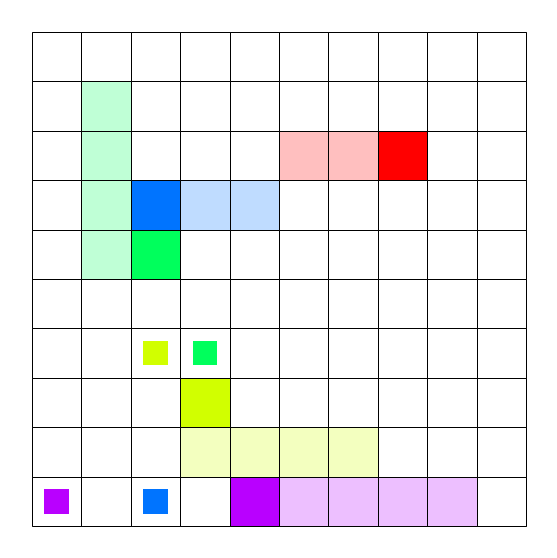

In [7]:
%matplotlib inline
env.render(states[10])